In [1]:
import os
import pandas as pd
import random

import sys
sys.path.insert(0, '..')

from unpast.run_unpast import unpast
from unpast.utils.method import prepare_input_matrix
from unpast.utils.consensus import make_consensus_biclusters

### Input and output

This example uses expressions of 200 randomly chosen samples from the TCGA-BRCA dataset (normalized and standardized log2(x+1) RNA-seq counts)

In [2]:
# input .tsv file; features in rows, samples in columns
exprs_file = "test_data_TCGA200/TCGA_200.exprs_z.tsv" 

# download input file if it is not found
if not os.path.exists(exprs_file):
    from gdown import download
    from zipfile import ZipFile

    url = 'https://drive.google.com/uc?id=1zee_GssqXCv_-tokLRJKR8cLksxsa8UN'
    output = 'TCGA200_example.zip'
    download(url, output, quiet=False)

    with ZipFile(output, 'r') as zip_ref:
        zip_ref.extractall()

    os.remove(output)

# or download and unzip it manually: https://drive.google.com/file/d/1zee_GssqXCv_-tokLRJKR8cLksxsa8UN/view?usp=drive_link# input .tsv file; features in rows, samples in columns

In [3]:
# input .tsv file; features in rows, samples in columns
exprs_file = "test_data_TCGA200/TCGA_200.exprs_z.tsv" 

In [4]:
# specify output folder and output file prefix
basename = 'TCGA200'
out_dir = "TCGA200_example/"

### Run UnPaSt 

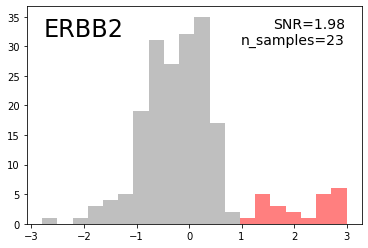

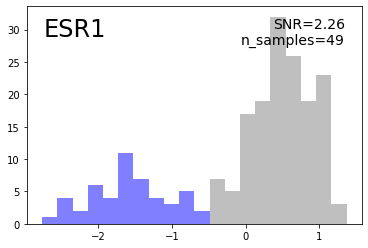

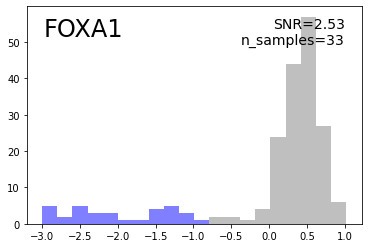

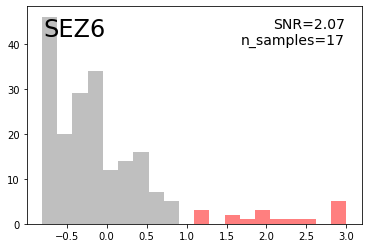

In [5]:
results = unpast(exprs_file,
            basename,
            out_dir=out_dir,
            # optional: show distributions of some selected features
            # known subtype-specific biomarkers are chosen in this example
            show_fits = ["ERBB2","ESR1","FOXA1","SEZ6"],
            seed = 42
            )

In [6]:
results.head(2)

,SNR,n_genes,n_samples,genes,samples,direction,genes_up,genes_down,gene_indexes,sample_indexes
0,3.528302,39,37,"{TMEM63C, HOXB2, CAPN13, CA8, LRFN2, ANKRD30B,...","{TCGA-A8-A08R-01, TCGA-BH-A0BL-01, TCGA-E2-A14...",DOWN,{},"{TMEM63C, HOXB2, CAPN13, SLC44A4, TFF3, SYT17,...","{1923, 388, 9990, 3847, 7176, 11795, 11159, 38...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,..."
1,2.453225,157,38,"{AMY1A, PRDM13, SPX, KLHL34, HAO1, SLC39A12, R...","{TCGA-A8-A08R-01, TCGA-BH-A0BL-01, TCGA-AR-A1A...",UP,"{AMY1A, PRDM13, SPX, KLHL34, HAO1, SLC39A12, R...",{},"{9729, 12290, 7681, 3077, 1035, 7695, 1553, 20...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,..."


### Re-run UnPaSt using previously computed binarization results

add `load = True`

In [7]:
results2 = unpast(exprs_file,
            basename,
            out_dir=out_dir,
            seed = 42,
            load= True, # try loading precomputed binarization results
            ds = 0 # e.g. with different feature clustering parameters
            )

### Re-run  UnPaSt with user-defined feature clustering function

define a function which accepts for input binarized features and outputs 1) a list of feature clusters (modules) 2) a list of not clustered features 

For example - `louvain_sim_jaccard()` function 
 - computes Jaccard similarities for binarized features
 - ignores weak similarities < sim_cutoff (replaces with 0)
 - applies Louvain clustering to find feature clusters


In [8]:
import numpy as np
import sknetwork
from sknetwork.clustering import Louvain, modularity
from scipy.sparse import csr_matrix


def louvain_clustering(similarity_matrix):
    feature_names = similarity_matrix.index.values
    sparse_matrix = csr_matrix(similarity_matrix)
    labels = Louvain().fit_transform(sparse_matrix)
        
    modules = []
    not_clustered_features = []
    for label in set(labels):
        ndx = np.argwhere(labels == label).reshape(1, -1)[0]
        fn = feature_names[ndx]
        if len(fn) > 1:
            modules.append(fn)
        else:
            not_clustered_features+=fn
            
    return modules, not_clustered_features

def louvain_sim_jaccard(df_bin_data, # binarized data
                        sim_cutoff = 1/3 # ignore weak overlaps with J<sim_cutoff
                       ):
    from unpast.utils.method import get_similarity_jaccard
    # calculate feature similarity matrix (Jaccard) for louvain clustering
    similarity_matrix = get_similarity_jaccard(df_bin_data,verbose = False)
    # ignore overlaps with J<sim_cutoff
    similarity_matrix[similarity_matrix <sim_cutoff] = 0
    # feature clustering
    modules, not_clustered_features = louvain_clustering(similarity_matrix)
    print("feature clusters: %s"%len(modules))
    return modules, not_clustered_features

In [9]:
results = unpast(exprs_file,
            basename,
            out_dir=out_dir,
            # use precomputed binarized features
            load=True,
            seed = 42,
            # cluster features with new method
            clust_method=louvain_sim_jaccard,
            # cluster up- and down-regulated features together
            directions=["BOTH"]
            )
results.sort_values("n_genes",ascending=False).head(5)

feature clusters: 29


,SNR,n_genes,n_samples,genes,samples,direction,genes_up,genes_down,gene_indexes,sample_indexes
8,2.093382,405,53,"{PPP4R4, SERPINA4, GHRH, FPR3, HMGCS2, TFAP2B,...","{TCGA-A8-A08R-01, TCGA-BH-A0BL-01, TCGA-C8-A26...",BOTH,"{LHX2, C11orf85, BEND7, EPHX4, MSL3P1, FRRS1L,...","{TBX1, NIPBL, PPP4R4, KNDC1, SLC50A1, SERPINA4...","{4110, 4113, 10280, 14377, 4138, 6187, 14383, ...","{128, 129, 2, 131, 4, 132, 134, 7, 135, 136, 1..."
0,3.047036,295,38,"{AMY1A, PRDM13, KLHL34, HAO1, SLC39A12, ELOVL2...","{TCGA-A8-A08R-01, TCGA-BH-A0BL-01, TCGA-AR-A1A...",BOTH,"{AMY1A, PRDM13, KLHL34, HAO1, SLC39A12, RLBP1,...","{ELOVL2, SLC44A5, AFF3, ANKRD30B, GFRA1, KCNK1...","{9729, 12290, 5121, 7681, 3077, 7176, 11785, 3...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 142, 145..."
26,1.40177,172,89,"{C14orf180, SPX, TBC1D3I, CTAGE6, IGF2-AS, ANG...","{TCGA-A8-A0A7-01, TCGA-A8-A0A6-01, TCGA-BH-A18...",BOTH,"{C14orf180, SPX, CTAGE6, IGF2-AS, ANGPTL7, ADG...","{TBC1D3I, AC018755.18, SLC35D3, TMEM70, SORCS3}","{13316, 3076, 5, 1544, 10761, 10769, 2583, 975...","{1, 4, 6, 8, 9, 10, 11, 14, 16, 20, 22, 23, 33..."
25,1.40757,16,81,"{DCAF13, GATA5, NOP56, SPRR3, TH, NMNAT3, MUC2...","{TCGA-A8-A0A7-01, TCGA-C8-A26X-01, TCGA-BH-A0H...",BOTH,"{DCAF13, GATA5, NOP56, SPRR3, TH, MUC21, HIST1...","{NMNAT3, RIMS2, ZNF311, ENHO}","{192, 5701, 3290, 4874, 2796, 14669, 12878, 84...","{7, 12, 13, 16, 19, 23, 25, 26, 27, 28, 30, 33..."
7,2.10802,13,18,"{MAGEA12, OR8G5, UPK1B, VCX3A, MAGEA4, CSAG2, ...","{TCGA-B6-A0X1-01, TCGA-A8-A08R-01, TCGA-A2-A0T...",UP,"{MAGEA12, OR8G5, UPK1B, VCX3A, MAGEA4, CSAG2, ...",{},"{3011, 13924, 3012, 7334, 9732, 7336, 8873, 73...","{96, 2, 66, 36, 39, 105, 10, 13, 46, 142, 80, ..."


### Read and write UnPaSt results

In [10]:
from unpast.utils.io import write_bic_table, read_bic_table

In [11]:
suffix = ".bin=kmeans,pval=0.01,clust=louvain_sim_jaccard,direction=BOTH"
seed = 42
bic_file = out_dir + "/"+basename+".seed="+str(seed)+suffix+".biclusters.tsv"
biclusters = read_bic_table(bic_file)
biclusters.head(2)

,SNR,n_genes,n_samples,genes,samples,direction,genes_up,genes_down,gene_indexes,sample_indexes
id,,,,,,,,,,
0,3.047036,295,38,"{AMY1A, PRDM13, KLHL34, HAO1, SLC39A12, ELOVL2...","{TCGA-A8-A08R-01, TCGA-BH-A0BL-01, TCGA-AR-A1A...",BOTH,"{AMY1A, PRDM13, KLHL34, HAO1, SLC39A12, RLBP1,...","{ELOVL2, SLC44A5, AFF3, ANKRD30B, GFRA1, KCNK1...","{5121, 9729, 12290, 7681, 3077, 7176, 11785, 3...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 142, 145..."
1,2.588335,5,16,"{COX7B2, MAGEC2, XAGE1B, XAGE1A, PAGE2}","{TCGA-A8-A08I-01, TCGA-EW-A1PC-01, TCGA-A8-A0A...",UP,"{COX7B2, MAGEC2, XAGE1B, XAGE1A, PAGE2}",{},"{2895, 7343, 8985, 14299, 14300}","{97, 66, 35, 39, 27, 105, 10, 142, 46, 80, 113..."


In [12]:
new_file_name = "TCGA200_example/TCGA200.biclusters.tsv"
write_bic_table(biclusters,new_file_name)

### Consensus biclusters from 5 runs

#### 1. Running UnPaSt five times with different seeds

* biclusters from individual runs:

\<basename>.seed=\<seed>.bin=kmeans,pval=0.01,clust=WGCNA,direction=DOWN-UP,ds=3,dch=0.995,max_power=10,precluster=True.biclusters.tsv


In [13]:
n_runs = 5
analysis_seed = 0
random.seed(analysis_seed)
seeds = []
for i in range(n_runs):
    seeds.append(random.randint(0,1000000))
print("generate ",n_runs," seeds",seeds)

generate  5  seeds [885440, 403958, 794772, 933488, 441001]


In [14]:
biclusters = []
for seed in seeds:
    results = unpast(exprs_file, basename,
                  out_dir=out_dir,
                  load=False,
                  seed = seed
                 )
    # make bicluster ids unique: 'seed=<seed>_<bicluster id>'
    results.index = ["seed="+str(seed)+"_"+str(x) for x in results.index.values ]
    biclusters.append(results)
    print("seed = %s\tn_biclusters: %s"%(seed, results.shape[0]))


seed = 885440	n_biclusters: 117
seed = 403958	n_biclusters: 146
seed = 794772	n_biclusters: 135
seed = 933488	n_biclusters: 118
seed = 441001	n_biclusters: 124


#### 2. Combine the results of five independent runs to consensus biclusters

In [15]:
exprs = pd.read_csv(exprs_file,sep="\t",index_col = 0)
# filter and z-score transform input matrix, limit z-scores to [-3,3]
exprs_z = prepare_input_matrix(exprs, min_n_samples=5,ceiling=3)
consensus_biclusters = make_consensus_biclusters(biclusters, exprs_z, 
                                                 seed = analysis_seed,
                                                 verbose = False
                                                )

consensus_biclusters.head(3)

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
0,2.847923,165,36,"{AMY1A, PRDM13, SPX, KLHL34, HAO1, SLC39A12, R...","{TCGA-A8-A08R-01, TCGA-BH-A0BL-01, TCGA-E2-A14...","{AMY1A, PRDM13, SPX, KLHL34, HAO1, SLC39A12, R...","{CAPN13, SLC44A4, MSX2, LRFN2, C9orf152, XBP1,...","{9729, 12290, 5121, 3077, 1553, 11795, 2068, 6...","{128, 2, 131, 4, 7, 136, 139, 12, 13, 145, 19,...",BOTH,18,"{seed=794772_4, seed=403958_6, seed=794772_7, ..."
1,2.472176,139,47,"{ELOVL2, AFF3, ANKRD30B, GFRA1, KCNK15, C9orf1...","{TCGA-A8-A08R-01, TCGA-BH-A0BL-01, TCGA-C8-A26...",{},"{ELOVL2, AFF3, ANKRD30B, GFRA1, KCNK15, C9orf1...","{3596, 1529, 5647, 11795, 20, 13331, 1558, 411...","{128, 2, 131, 4, 132, 134, 7, 135, 136, 139, 1...",DOWN,6,"{seed=441001_3, seed=933488_10, seed=885440_1,..."
2,2.34625,2,19,"{ODAM, PRR27}","{TCGA-BH-A0BL-01, TCGA-AN-A0FL-01, TCGA-BH-A0W...","{ODAM, PRR27}",{},"{8819, 9996}","{2, 4, 139, 19, 22, 24, 165, 166, 48, 183, 58,...",UP,3,"{seed=403958_5, seed=885440_15, seed=794772_5}"


# Example biclusters 


In [16]:
g = "ERBB2"
b = consensus_biclusters
b[b["genes"].apply(lambda x: g in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
31,1.708024,15,20,"{SERHL2, UGT2B10, ADAM2, DMRTC2, ZP2, PGAP3, N...","{TCGA-A8-A0A7-01, TCGA-A8-A097-01, TCGA-AN-A04...","{SERHL2, UGT2B10, ADAM2, DMRTC2, TGM4, PGAP3, ...",{},"{3552, 14946, 10075, 11338, 12074, 12875, 9294...","{129, 132, 134, 149, 28, 29, 39, 46, 47, 54, 6...",UP,5,"{seed=403958_16, seed=441001_38, seed=885440_1..."


In [17]:
g = "ESR1"
b[b["genes"].apply(lambda x: g in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
1,2.472176,139,47,"{ELOVL2, AFF3, ANKRD30B, GFRA1, KCNK15, C9orf1...","{TCGA-A8-A08R-01, TCGA-BH-A0BL-01, TCGA-C8-A26...",{},"{ELOVL2, AFF3, ANKRD30B, GFRA1, KCNK15, C9orf1...","{3596, 1529, 5647, 11795, 20, 13331, 1558, 411...","{128, 2, 131, 4, 132, 134, 7, 135, 136, 139, 1...",DOWN,6,"{seed=441001_3, seed=933488_10, seed=885440_1,..."


In [18]:
g = "SYT4"
b= consensus_biclusters
b[b["genes"].apply(lambda x: g in x)]

,SNR,n_genes,n_samples,genes,samples,genes_up,genes_down,gene_indexes,sample_indexes,direction,detected_n_times,ids
27,1.734242,10,17,"{SYT4, CARTPT, SVOP, AMER3, CPLX2, LRTM2, LIN2...","{TCGA-C8-A1HK-01, TCGA-E2-A15S-01, TCGA-A8-A08...","{CARTPT, SVOP, AMER3, CPLX2, LRTM2, LIN28A, KC...",{},"{11392, 2913, 12579, 6442, 12523, 1875, 9140, ...","{33, 98, 35, 162, 134, 103, 168, 77, 17, 177, ...",UP,5,"{seed=794772_73, seed=441001_12, seed=885440_9..."


### Plot heatmap for selected biclusters
* Basal: 0,lightblue
* Her2+: 31,yellow
* Neuroendocrine: 27,orange

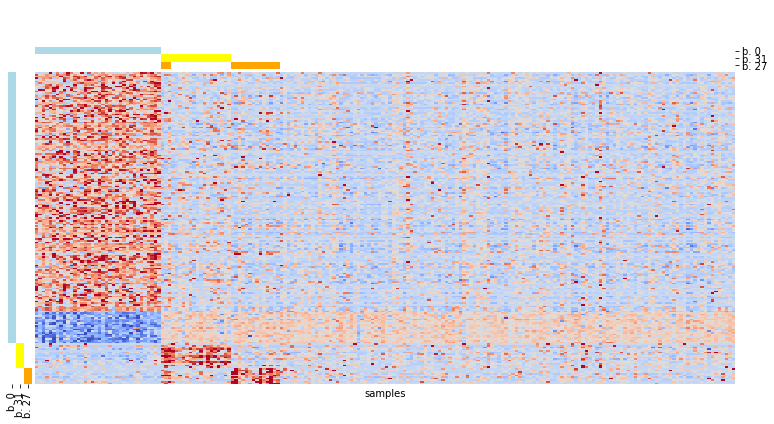

In [19]:
from unpast.utils.figs import draw_heatmap2
from unpast.utils.method import zscore

# select several biclusters to plot
i = [0,31,27] 
b = consensus_biclusters.loc[i,:]


tmp = draw_heatmap2(exprs_z ,b,
              bicluster_colors=["lightblue","yellow","orange"], # "auto",
              figsize = (12,6), 
              dendrogram_ratio=(0.1,0.1),
              colors_ratio=(0.02/12*6, 0.02),
              bic_prefix = "b. ",
              no_cbar=True,
              col_labels = False,
              row_labels = False,
              no_row_colors = False,
              cluster_rows=False
             )

#### neuroendocrine with gene names

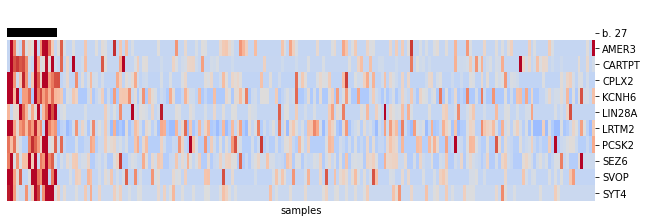

In [20]:
tmp = draw_heatmap2(exprs_z ,b.loc[[27],:],
              figsize = (10,3), 
              dendrogram_ratio=(0.1,0.1),
              colors_ratio=(0.05/10*4, 0.05),
              bic_prefix = "b. ",
              no_cbar=True,
              col_labels = False,
              row_labels = True,
              no_row_colors = True,
              cluster_rows=False
             )